# Dacon Parking Demand Prediction 

## 대회 소개

건물 유형별 임대주택 설계시 단지 내 적정 주차 수요를 예측하는 AI 모델 개발하는 것입니다. 

### 데이터 
- 유형: 정형데이터
- 학습 데이터: features로는 **시도, 건물 유형, 건물 가격, 건물 위치, 단지내 주차면수** 가 있고, target은 **등록 차량수** 입니다.
- 현재 등록된 차랑 수 데이터 학습을 통해 건물에 따른 등록 차량수가 어느정도 일지를 예측하는 문제입니다.

### 평가식
- MAE: Mean Absolute Error
$$MAE = \sum |y_{pred} - y_{true}| $$

In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import missingno as msno # 결측치 시각화
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_path = 'C:\\Users\\USER\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

%matplotlib inline

In [2]:
FOLDER_PATH = os.path.join(os.sys.path[0], "235745_parking_data/")

In [3]:
train_dataset = pd.read_csv(os.path.join(FOLDER_PATH, "train.csv"))
test_dataset = pd.read_csv(os.path.join(FOLDER_PATH, "test.csv"))
age_gender_info_dataset = pd.read_csv(os.path.join(FOLDER_PATH, "age_gender_info.csv"))

In [4]:
# train parking dataset

train_dataset.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [5]:
# test parking dataset

test_dataset.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [6]:
# age_gender_info

age_gender_info_dataset.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [7]:
print("The Number of row: Train Data %d" % len(train_dataset))
print("The Number of row: Test Data %d" % len(test_dataset))
print("The Number of row: Gender and age info Data %d" % len(age_gender_info_dataset))

The Number of row: Train Data 2952
The Number of row: Test Data 1022
The Number of row: Gender and age info Data 16


- Train dataset이 많지 않음. oversampling을 고려해볼 필요가 있음.
- Train vs. Test dataset 비율이 3:1 정도임.

# 결측치 확인

In [8]:
def null_visualization(df, graph_type):
    '''
    variable
    '''
    if(graph_type == "matrix"):
        msno.matrix(df)
    elif(graph_type == "bar"):
        msno.bar(df)
    elif(graph_type == "heatmap"):
        msno.heatmap(df)
    elif(graph_type == "dendrogram"):
        msno.dendrogram(df)

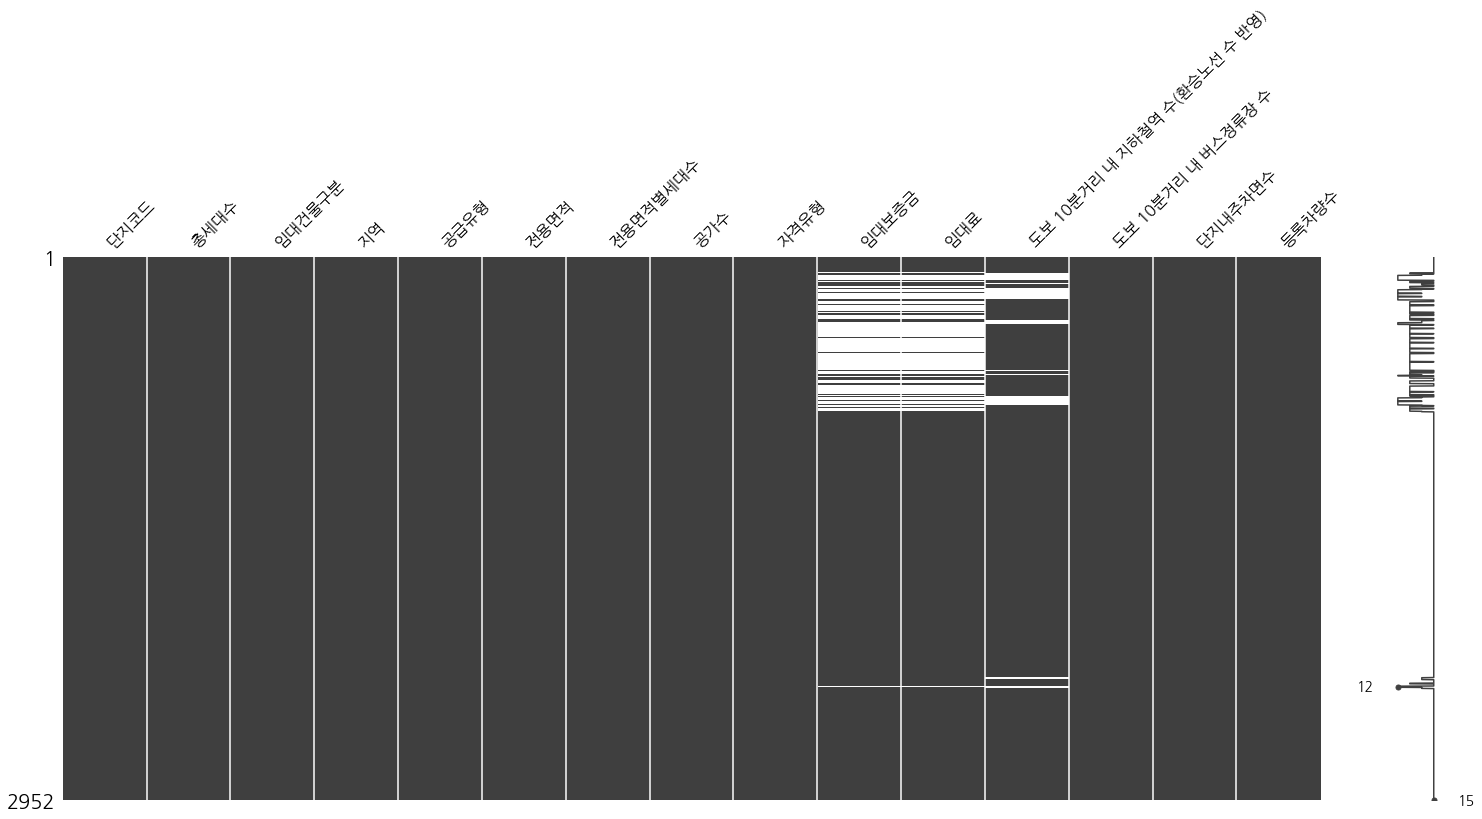

In [9]:
null_visualization(train_dataset, "matrix")

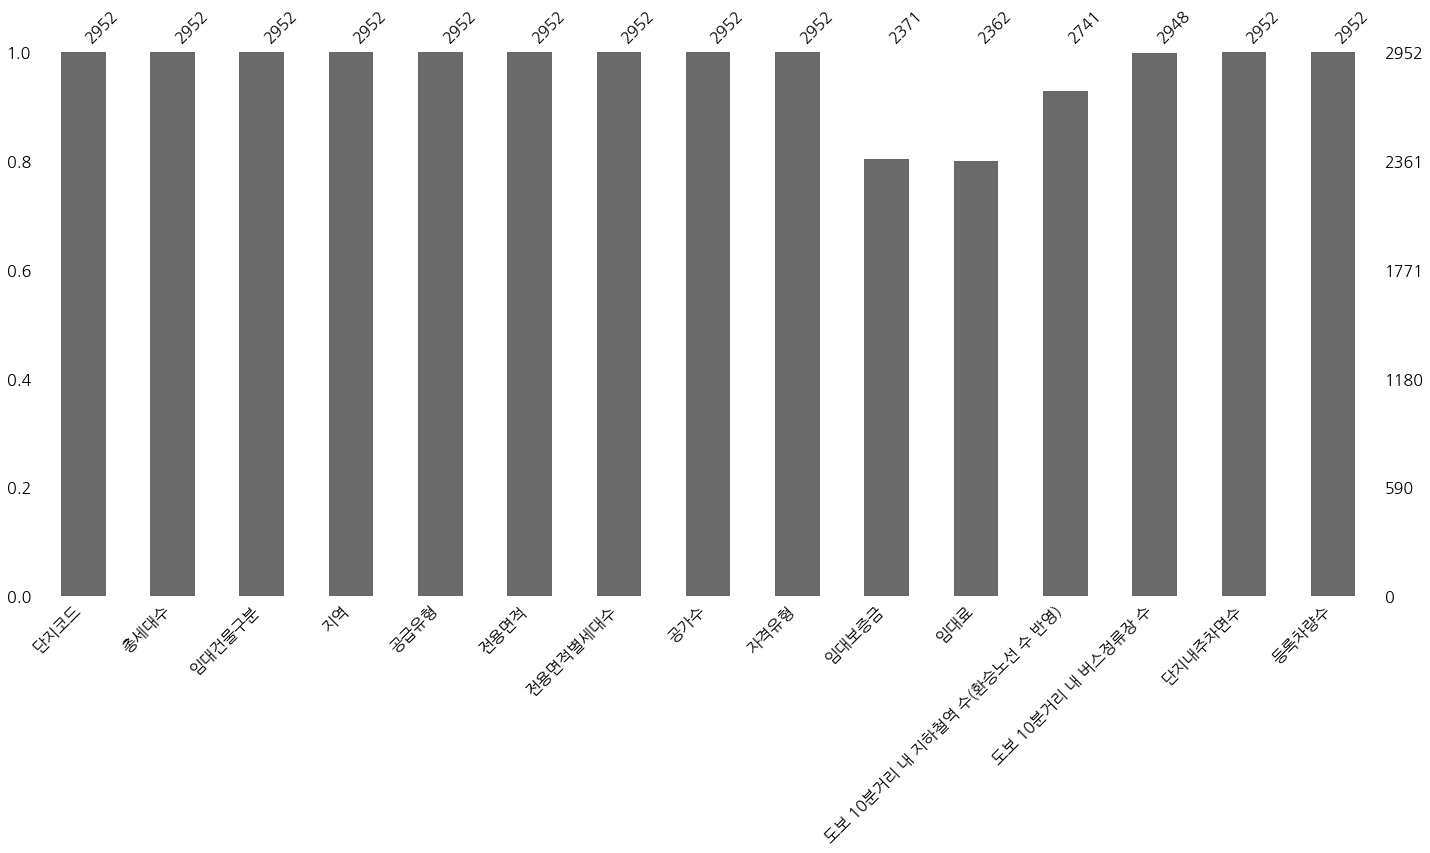

In [32]:
null_visualization(train_dataset, "bar")

- 임대보증금, 임대료 column에서 많은 결측값이 발생하고 있음.
- 도보 10분거리 내 지하철역 수에서도 결측값 발생하고 있음. (결측값이 발생한 이유를 생각해볼 필요가 있을 듯)
- 도보 10분거리 내 버스정류장 수에서도 4개의 결측값이 발생하고 있음.

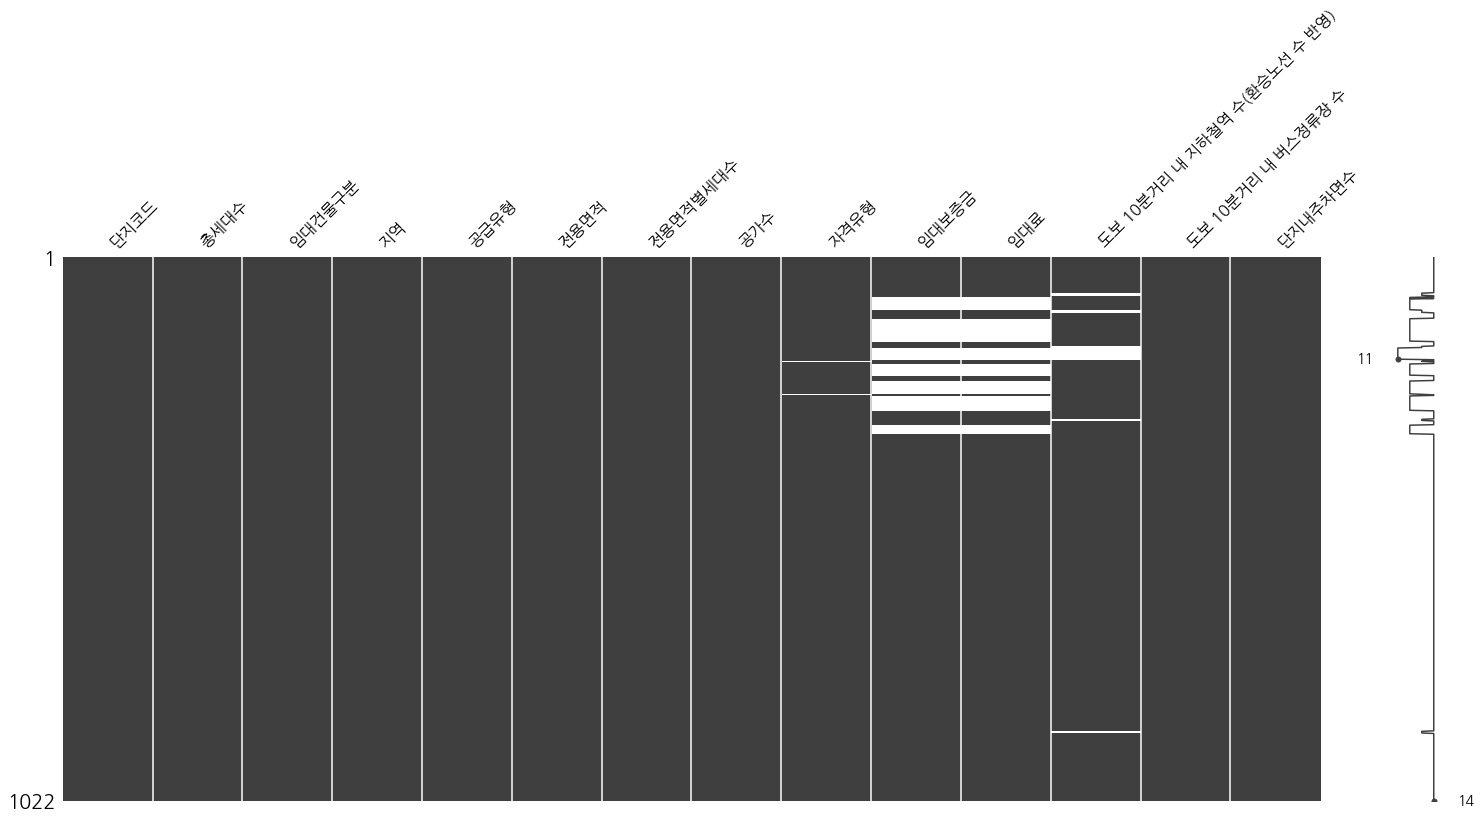

In [10]:
null_visualization(test_dataset, "matrix")

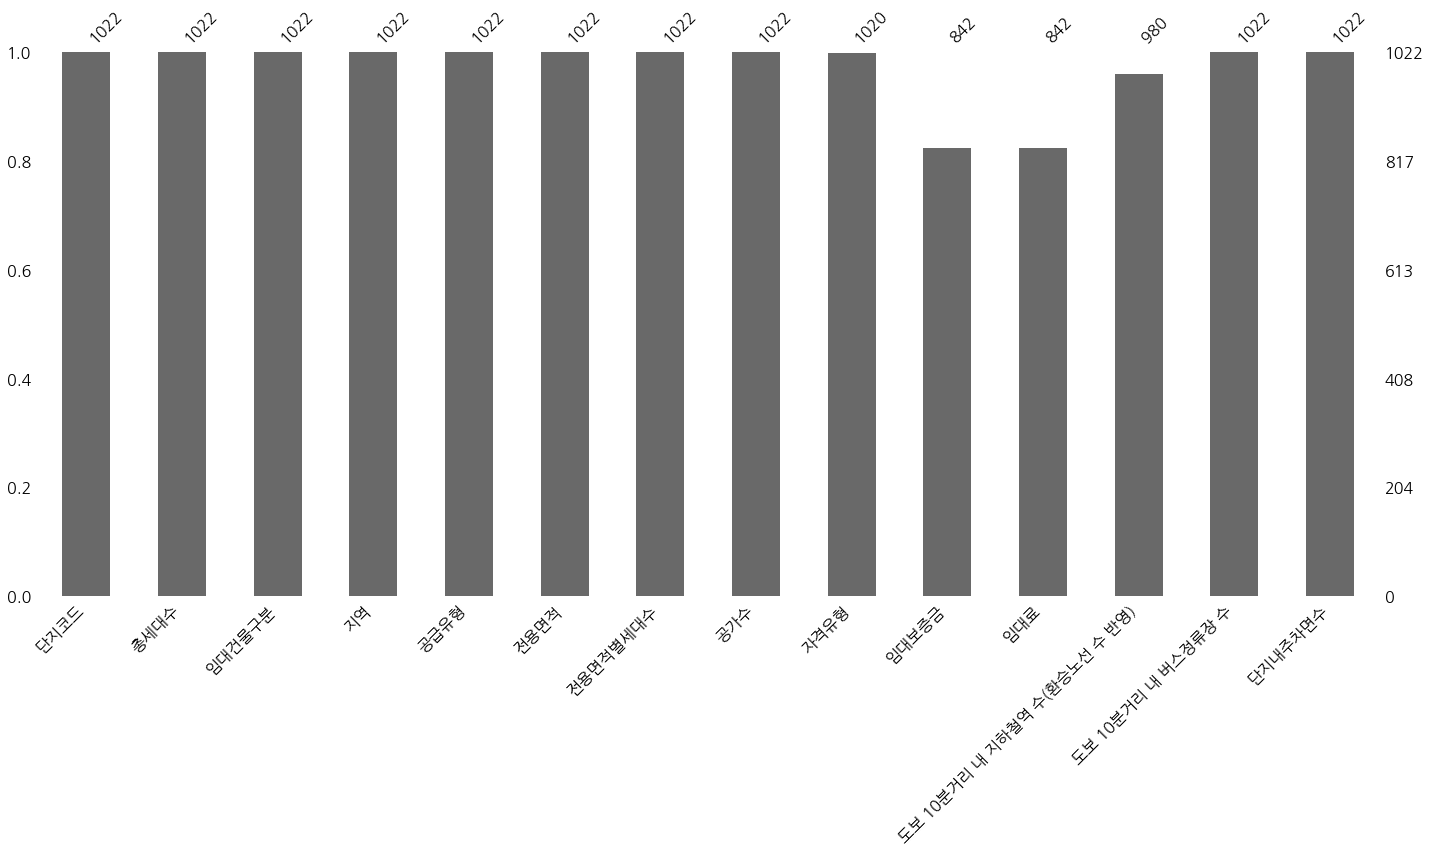

In [33]:
null_visualization(test_dataset, "bar")

- train_dataset과 비슷하게 임대보증금, 임대료, 도보 10분거리 내 지하철역 수 column에서 많은 결측값이 발생하고 있음.
- train_dataset과 다르게 자격 유형에도 결측값이 발생하고 있음.

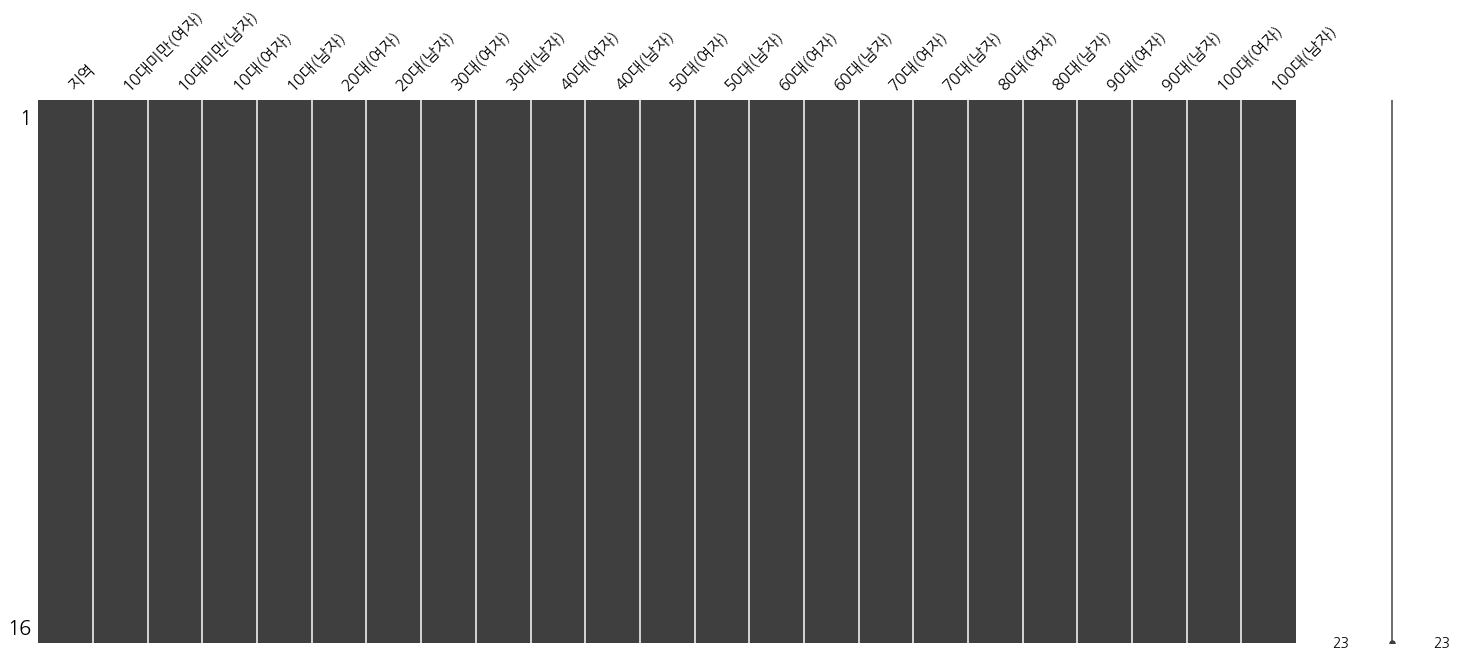

In [35]:
null_visualization(age_gender_info_dataset, "matrix")

- 결측값 없음

# EDA

In [136]:
train_dataset.dtypes["임대료"] == "float64"

True

## Column Type 변환

In [137]:
all_column = train_dataset.columns
num_column = []
cat_column = []
target_column = "등록차량수"
for col in all_column:
    if train_dataset.dtypes[col] == "object":
        cat_column.append(col)
    elif train_dataset.dtypes[col] == "int64" or train_dataset.dtypes[col] == "float64":
        num_column.append(col)

### Train_dataset

In [36]:
# 결측값 형태 확인
for index, row in train_dataset[["임대보증금", "임대료", "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]].iterrows():
    try:
        int(row["임대보증금"])
        int(row["임대료"])
        int(row["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])
        int(row["도보 10분거리 내 버스정류장 수"])
    except:
        print(index, row["임대보증금"], row["임대료"], row["도보 10분거리 내 지하철역 수(환승노선 수 반영)"], row["도보 10분거리 내 버스정류장 수"])

88 nan nan 0.0 4.0
89 nan nan 0.0 4.0
90 nan nan 0.0 4.0
91 nan nan 0.0 4.0
94 17460000.0 122210.0 nan 3.0
95 17460000.0 122210.0 nan 3.0
96 19954000.0 130940.0 nan 3.0
97 28687000.0 149660.0 nan 3.0
98 3141000.0 69900.0 nan 2.0
99 3141000.0 69900.0 nan 2.0
100 3731000.0 83020.0 nan 2.0
101 nan nan nan 2.0
102 nan nan nan 2.0
103 nan nan nan 2.0
104 nan nan nan 2.0
105 nan nan nan 2.0
106 nan nan nan 2.0
107 nan nan nan 2.0
108 nan nan nan 2.0
109 nan nan nan 2.0
110 nan nan nan 2.0
111 nan nan nan 2.0
112 nan nan nan 2.0
113 nan nan nan 2.0
114 nan nan nan 2.0
115 nan nan nan 2.0
116 nan nan nan 2.0
117 nan nan nan 2.0
118 nan nan nan 2.0
119 nan nan nan 2.0
120 nan nan nan 2.0
121 nan nan nan 2.0
122 nan nan nan 2.0
123 nan nan nan 2.0
124 nan nan nan 2.0
125 nan nan nan 2.0
126 nan nan nan 2.0
127 nan nan nan 2.0
133 nan nan 0.0 5.0
134 nan nan 0.0 5.0
135 nan nan 0.0 5.0
136 nan nan 0.0 5.0
137 nan nan 0.0 5.0
138 nan nan 0.0 5.0
139 nan nan 0.0 5.0
140 nan nan 0.0 5.0
144 14247000

738 nan nan 0.0 4.0
739 nan nan 0.0 4.0
740 nan nan 0.0 4.0
741 nan nan 0.0 4.0
742 nan nan 0.0 4.0
743 nan nan 0.0 4.0
744 nan nan 0.0 4.0
745 nan nan 0.0 4.0
746 nan nan 0.0 4.0
747 nan nan 0.0 4.0
748 nan nan 0.0 4.0
753 nan nan 0.0 3.0
754 nan nan 0.0 3.0
755 nan nan 0.0 3.0
756 nan nan 0.0 3.0
761 16205000.0 208470.0 nan 8.0
762 16348000.0 210900.0 nan 8.0
763 18770000.0 246770.0 nan 8.0
764 4682000.0 104180.0 nan 2.0
765 4728000.0 105210.0 nan 2.0
766 nan nan nan 2.0
767 nan nan nan 2.0
768 nan nan nan 2.0
769 nan nan nan 2.0
770 nan nan nan 2.0
771 nan nan nan 2.0
772 nan nan nan 2.0
773 nan nan nan 2.0
774 nan nan nan 2.0
775 nan nan nan 2.0
776 nan nan nan 2.0
777 nan nan nan 2.0
778 nan nan nan 2.0
779 nan nan nan 2.0
780 nan nan nan 2.0
781 nan nan nan 2.0
782 nan nan nan 2.0
783 3141000.0 69900.0 nan 8.0
784 3141000.0 69900.0 nan 8.0
785 3731000.0 83020.0 nan 8.0
786 nan nan nan 8.0
787 nan nan nan 8.0
788 nan nan nan 8.0
789 nan nan nan 8.0
790 nan nan nan 8.0
791 nan nan 

In [44]:
def string_missing_value_to_nan(df, columns, change_types):
    '''
    variables
    '''
    for index, row in df[columns].iterrows():
        for col, dtype in zip(columns, change_types):
            if "int" in dtype:
                try:
                    int(df.loc[index, col])
                except:
                    df.loc[index, col] = np.nan
            elif "float" in dtype:
                try:
                    float(df.loc[index, col])
                except:
                    df.loc[index, col] = np.nan
            elif "string" in dtype:
                # TODO
                raise Exception(NotImplemented)
            elif "object"in dtype:
                #TODO
                raise Exception(NotImplemented)

In [37]:
string_missing_value_to_nan(train_dataset, ["임대보증금", "임대료", "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"], ["float64"]*4)

- 결측치 중, nan인 것도 있고, "-" string 처리로 되어있는 데이터도 있음.
- 임대보증금, 임대료 column이 objec type으로 되어있음. > float64로 변경

In [38]:
type_conversion_dict = {
    "임대보증금": "float64",
    "임대료": "float64",
    "도보 10분거리 내 지하철역 수(환승노선 수 반영)": "float64",
    "도보 10분거리 내 버스정류장 수": "float64"
}

In [43]:
train_dataset = train_dataset.astype(type_conversion_dict)
train_dataset.dtypes

단지코드                             object
총세대수                              int64
임대건물구분                           object
지역                               object
공급유형                             object
전용면적                            float64
전용면적별세대수                          int64
공가수                             float64
자격유형                             object
임대보증금                           float64
임대료                             float64
도보 10분거리 내 지하철역 수(환승노선 수 반영)    float64
도보 10분거리 내 버스정류장 수              float64
단지내주차면수                         float64
등록차량수                           float64
dtype: object

### Test_dataset

In [42]:
# test_dataset 결측값 형태 확인
for index, row in test_dataset[["자격유형", "임대보증금", "임대료", "도보 10분거리 내 지하철역 수(환승노선 수 반영)"]].iterrows():
    try:
        int(row["임대보증금"])
        int(row["임대료"])
        int(row["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])
        int(row["자격유형"])
    except:
        print(index, row["임대보증금"], row["임대료"], row["도보 10분거리 내 지하철역 수(환승노선 수 반영)"], row["자격유형"])

0 22830000 189840 0.0 H
1 36048000 249930 0.0 A
2 36048000 249930 0.0 H
3 36048000 249930 0.0 H
4 43497000 296780 0.0 H
5 43497000 296780 0.0 H
6 43497000 296780 0.0 H
7 43497000 296780 0.0 H
8 22830000 189840 0.0 H
9 22830000 189840 0.0 H
10 22830000 189840 0.0 A
11 36048000 249930 0.0 A
12 36048000 249930 0.0 A
13 36048000 249930 0.0 H
14 43497000 296780 0.0 A
15 43497000 296780 0.0 H
16 43497000 296780 0.0 H
17 19706000 156200 0.0 A
18 26435000 192250 0.0 A
19 26435000 192250 0.0 A
20 26435000 192250 0.0 A
21 36048000 234300 0.0 A
22 36048000 234300 0.0 A
23 36048000 234300 0.0 A
24 43257000 264350 0.0 A
25 55275000 312420 0.0 A
26 14418000 108130 0.0 A
27 14418000 108130 0.0 A
28 21628000 132160 0.0 A
29 25233000 144180 0.0 A
30 28598000 203050 0.0 H
31 28598000 203050 0.0 H
32 42776000 302800 0.0 H
33 42776000 302800 0.0 H
34 42776000 302800 0.0 H
35 42776000 302800 0.0 H
36 51188000 362870 0.0 H
37 51188000 362870 0.0 H
38 30040000 206380 0.0 A
39 30040000 206380 0.0 A
40 3148100

544 17602000 121850 0.0 A
545 13276000 107740 0.0 A
546 13276000 107740 0.0 A
547 16439000 145120 0.0 A
548 16439000 145120 0.0 A
549 18175000 153180 0.0 A
550 18175000 153180 0.0 A
551 18175000 153180 0.0 A
552 18175000 153180 0.0 A
553 24665000 221980 0.0 A
554 24665000 221980 0.0 A
555 24665000 221980 0.0 A
556 24665000 221980 0.0 A
557 31157000 272630 0.0 A
558 31157000 272630 0.0 A
559 18175000 153180 0.0 A
560 18175000 153180 0.0 A
561 18175000 153180 0.0 A
562 24665000 221980 0.0 A
563 31157000 272630 0.0 A
564 31157000 272630 0.0 A
565 41543000 345330 0.0 A
566 16649000 163940 0.0 A
567 19953000 193180 0.0 A
568 19953000 193180 0.0 A
569 22241000 250370 0.0 A
570 25544000 287220 0.0 A
571 25544000 287220 0.0 A
572 25293000 255690 0.0 A
573 25293000 255690 0.0 A
574 25293000 255690 0.0 A
575 20233000 182630 1.0 A
576 23394000 217960 1.0 A
577 23394000 217960 1.0 A
578 29086000 293490 1.0 A
579 18476000 154790 0.0 A
580 34082000 232200 0.0 A
581 34082000 232200 0.0 A
582 34082000

946 31650000 174000 0.0 N
947 31650000 174000 0.0 N
948 5910000 122000 0.0 A
949 5910000 122000 0.0 A
950 14920000 188000 0.0 A
951 9150000 88000 0.0 C
952 14145000 77790 0.0 L
953 2312000 51450 0.0 C
954 3111000 69240 0.0 C
955 16768000 86630 0.0 J
956 25504000 131770 0.0 J
957 25504000 131770 0.0 J
958 26364000 136210 0.0 J
959 34340000 177420 0.0 J
960 12480000 78000 0.0 J
961 12480000 78000 0.0 J
962 12480000 78000 0.0 J
963 12480000 78000 0.0 J
964 18840000 117750 0.0 J
965 18840000 117750 0.0 J
966 18840000 117750 0.0 J
967 18840000 117750 0.0 J
968 18840000 117750 0.0 J
969 18840000 117750 0.0 J
970 18840000 117750 0.0 J
971 18840000 117750 0.0 J
972 25600000 160000 0.0 J
973 25600000 160000 0.0 J
974 25600000 160000 0.0 J
975 25600000 160000 0.0 J
976 25600000 160000 0.0 J
977 25600000 160000 0.0 J
978 25600000 160000 0.0 J
979 25600000 160000 0.0 J
980 25600000 160000 0.0 J
981 25600000 160000 0.0 J
982 14498000 62940 0.0 J
983 14498000 62940 0.0 J
984 14498000 62940 0.0 J
985

In [45]:
string_missing_value_to_nan(test_dataset, ["임대보증금", "임대료", "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"], ["float64"]*4)

In [46]:
test_dataset = test_dataset.astype(type_conversion_dict)
test_dataset.dtypes

단지코드                             object
총세대수                              int64
임대건물구분                           object
지역                               object
공급유형                             object
전용면적                            float64
전용면적별세대수                          int64
공가수                             float64
자격유형                             object
임대보증금                           float64
임대료                             float64
도보 10분거리 내 지하철역 수(환승노선 수 반영)    float64
도보 10분거리 내 버스정류장 수              float64
단지내주차면수                         float64
dtype: object

### 각 Column당 값 확인

In [103]:
def column_check(df, col_name, dtype):
    nonNullCol = "총세대수"
    if ("object" in dtype):
        fig, ax = plt.subplots(1, 1, figsize = (20, 10))
        print("Unique %s 갯수:" %col_name, len(df[col_name].unique()))
        print("%s 당 세대수 값 평균:" %col_name, df.groupby(col_name).count()[nonNullCol].mean())
        train_dataset.groupby(col_name).count()[nonNullCol].plot.bar() # non-NA 갯수
        plt.show()
    elif (("float" in dtype) or ("int" in dtype)):
        fit, ax = plt.subplots(1, 1, figsize = (20, 10))

        print("%s 평균:" %col_name, train_dataset[col_name].mean())
        print("%s 표준편차:" %col_name, train_dataset[col_name].std())
        train_dataset[col_name].hist()
        plt.show()

Unique 단지코드 갯수: 423
단지코드 당 세대수 값 평균: 6.9787234042553195


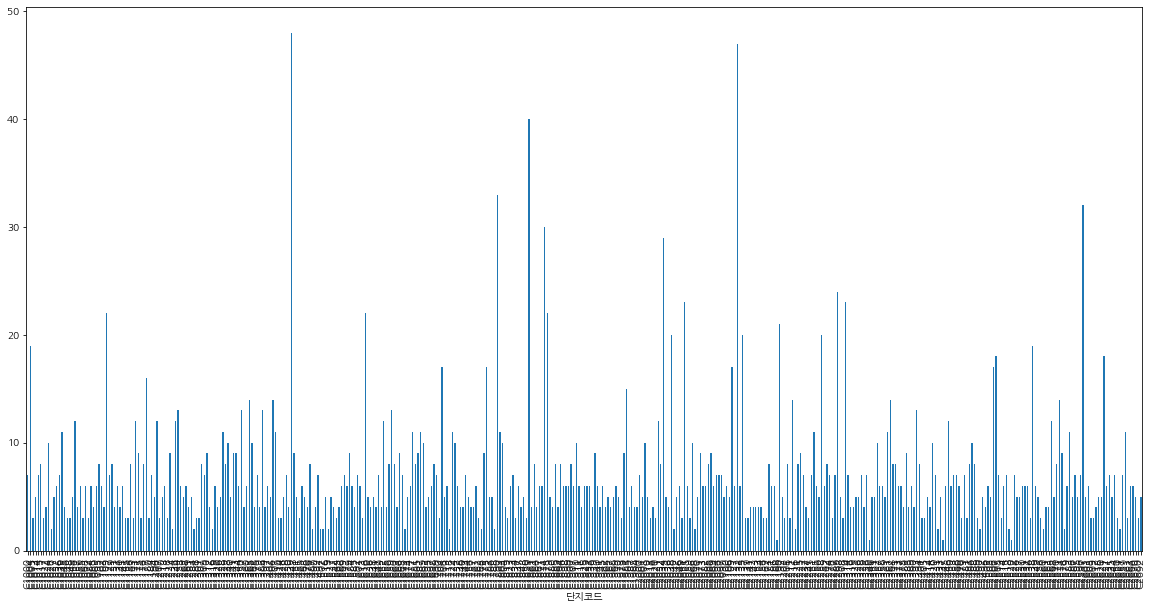

In [104]:
# 단지코드
# type: object

column_check(train_dataset, "단지코드", "object")

총세대수 평균: 886.6612466124661
총세대수 표준편차: 513.5401675056052


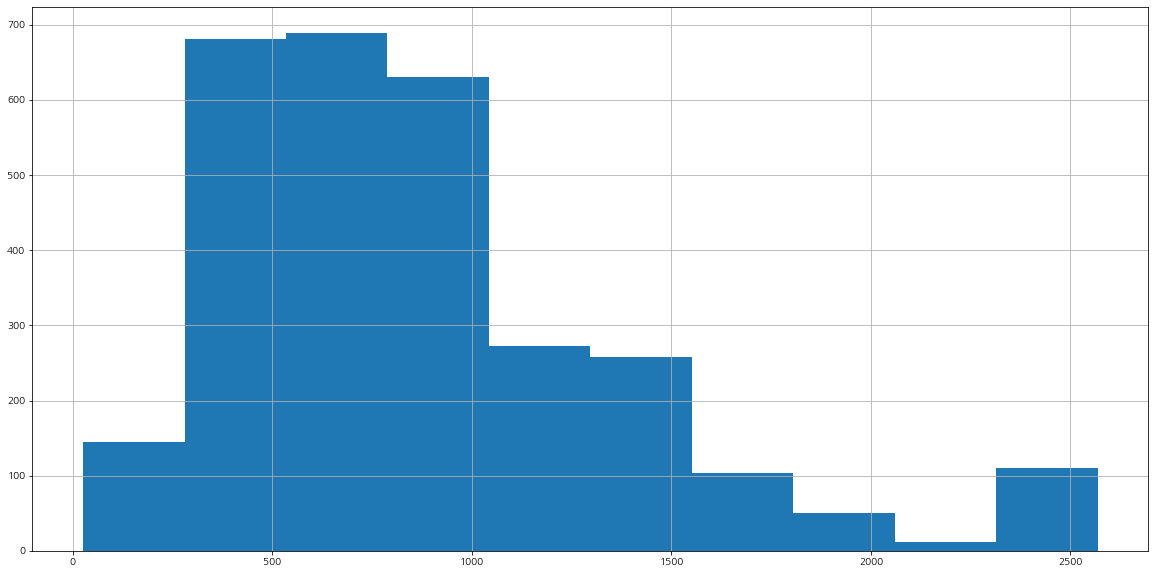

In [105]:
# 총세대수
# type: int64

column_check(train_dataset, "총세대수", "int64")

Unique 임대건물구분 갯수: 2
임대건물구분 당 세대수 값 평균: 1476.0


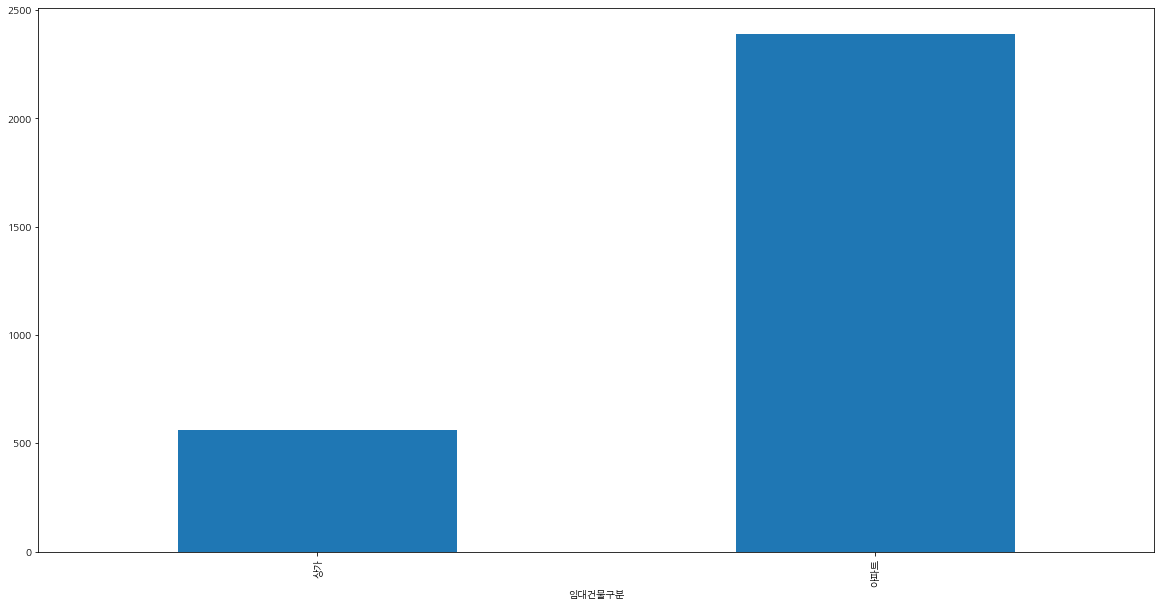

In [106]:
# 임대건물구분
# type: object

column_check(train_dataset, "임대건물구분", "object")

Unique 지역 갯수: 16
지역 당 세대수 값 평균: 184.5


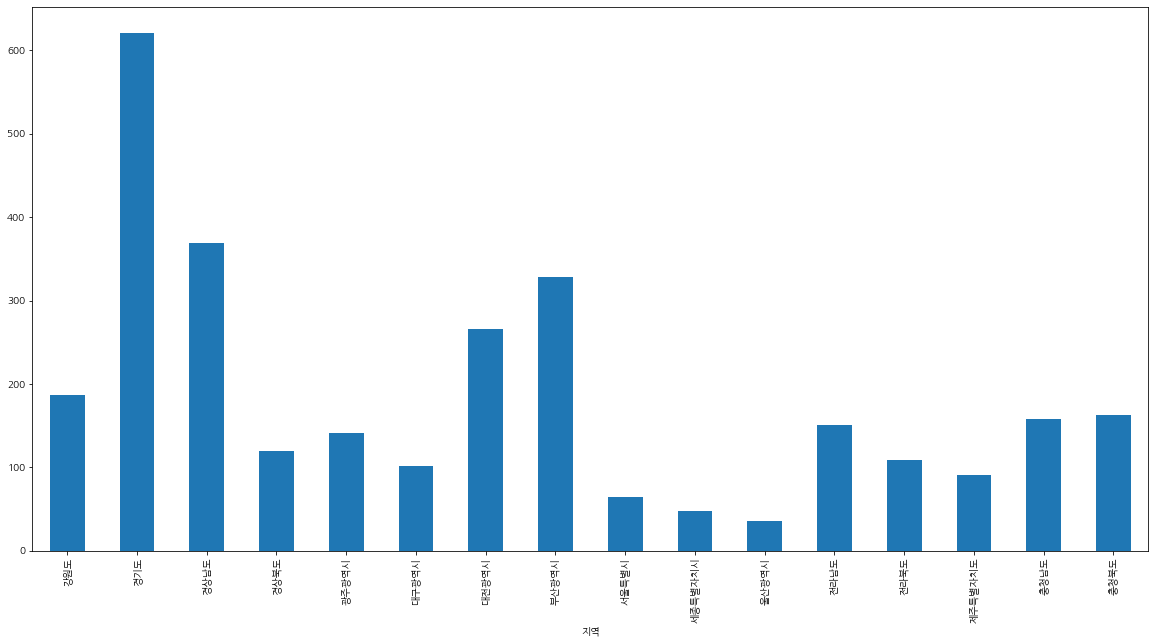

In [107]:
# 지역
# type: object

column_check(train_dataset, "지역", "object")

Unique 공급유형 갯수: 10
공급유형 당 세대수 값 평균: 295.2


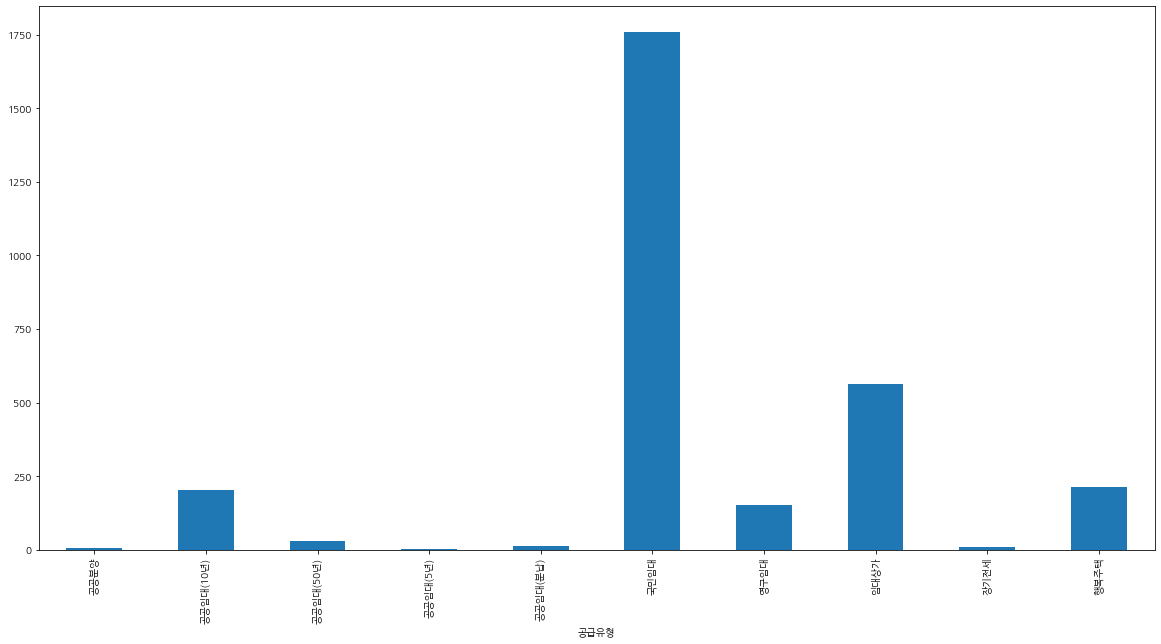

In [108]:
# 공급유형
# type: object

column_check(train_dataset, "공급유형", "object")

전용면적 평균: 44.757215447154465
전용면적 표준편차: 31.874280037774305


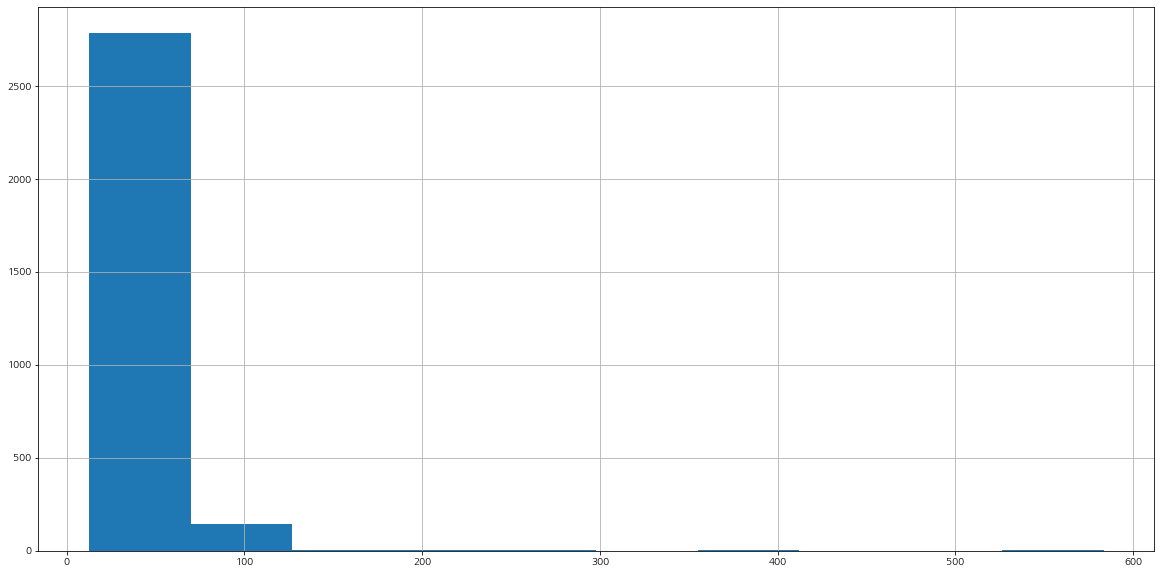

In [109]:
# 전용면적
# type: float64

column_check(train_dataset, "전용면적", "float64")

전용면적별세대수 평균: 102.7479674796748
전용면적별세대수 표준편차: 132.6401594168998


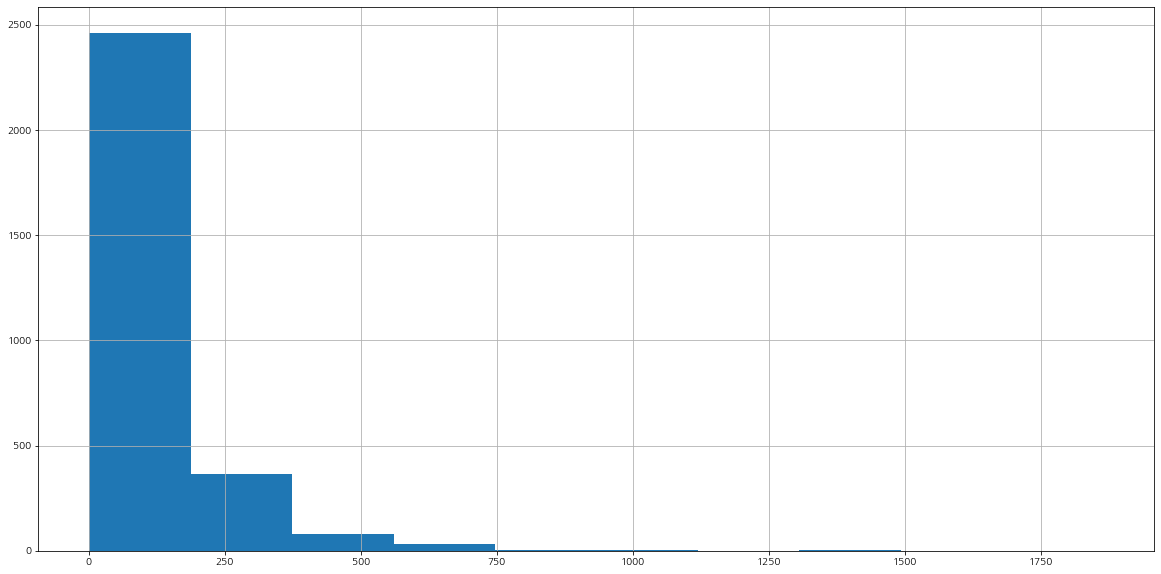

In [110]:
# 전용면적별세대수
# type: int64

column_check(train_dataset, "전용면적별세대수", "int64")

공가수 평균: 12.921070460704607
공가수 표준편차: 10.778830888806842


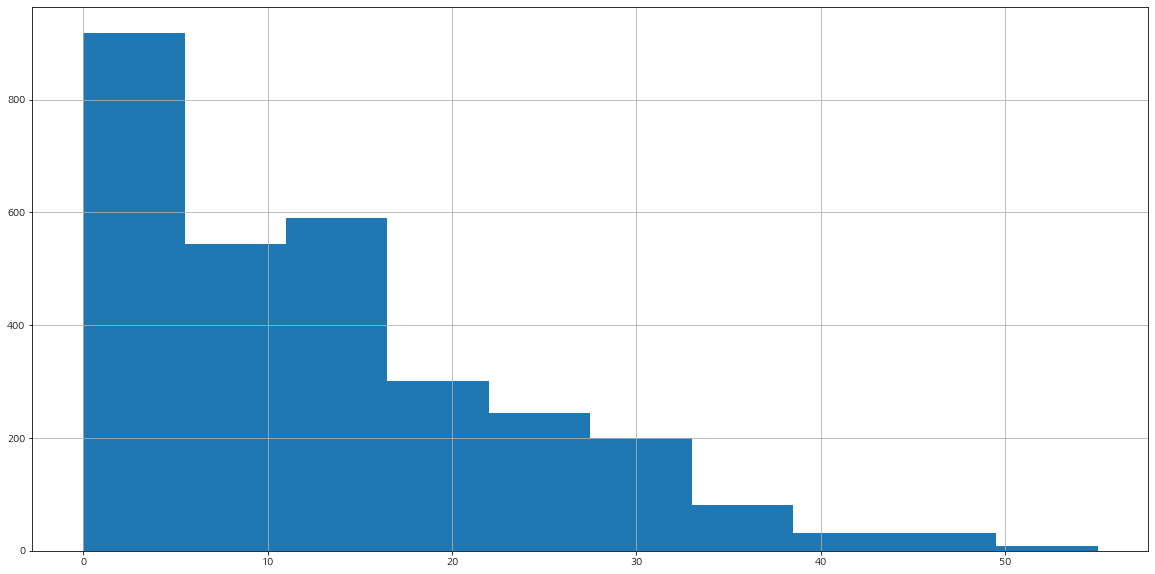

In [111]:
# 공가수
# type: float64

column_check(train_dataset, "공가수", "float64")

Unique 자격유형 갯수: 15
자격유형 당 세대수 값 평균: 196.8


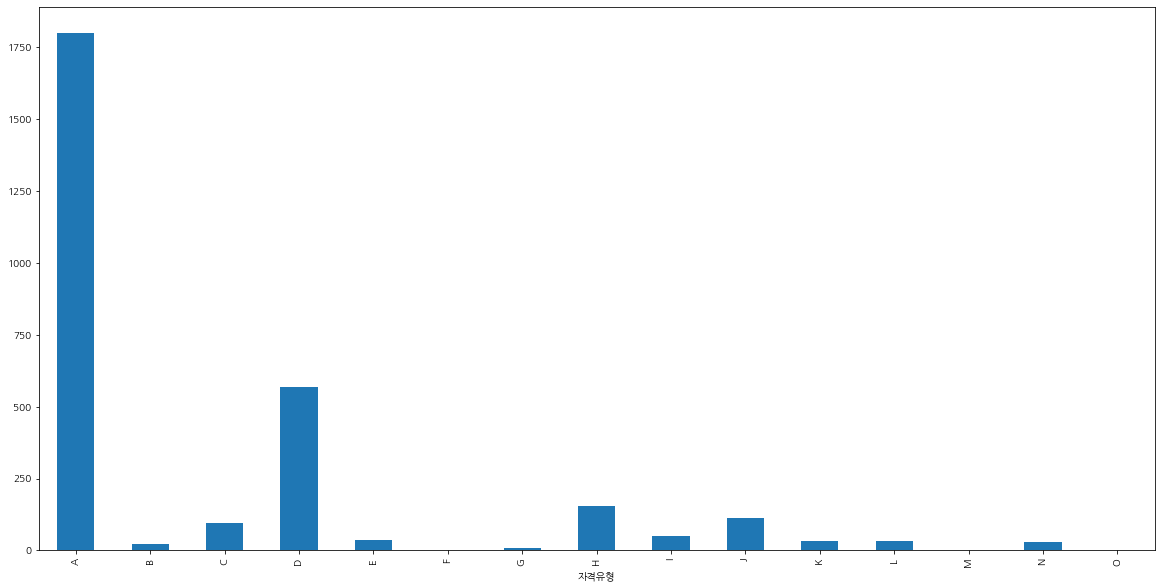

In [112]:
# 자격유형
# type: object

column_check(train_dataset, "자격유형", "object")

임대보증금 평균: 26864318.09363138
임대보증금 표준편차: 21613908.817007072


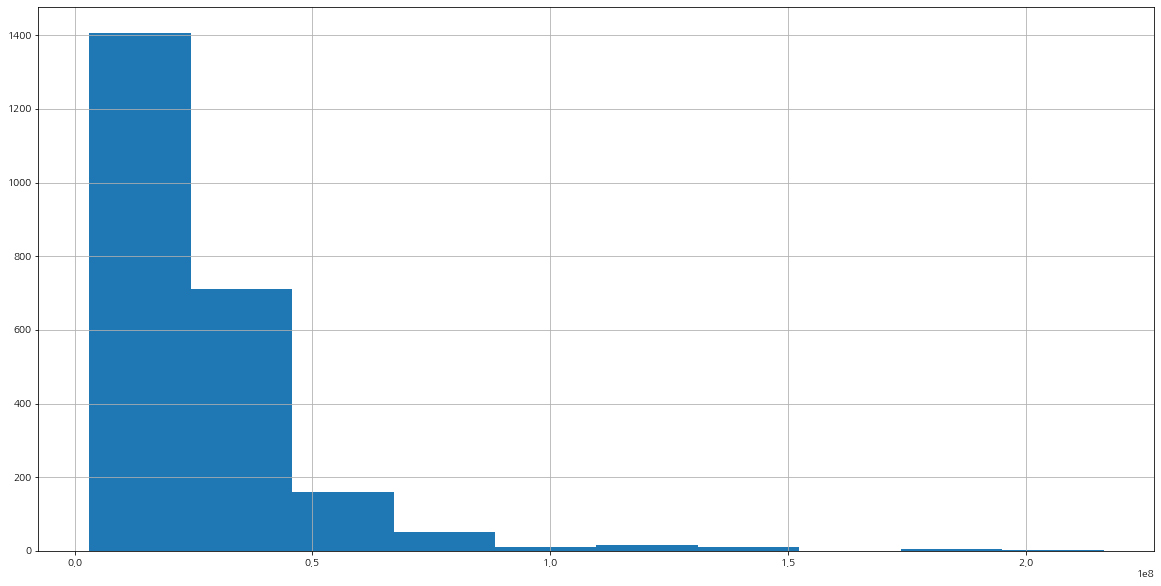

In [113]:
# 임대보증금
# type: float64

column_check(train_dataset, "임대보증금", "float64")

임대료 평균: 195718.08213378492
임대료 표준편차: 130374.45477656081


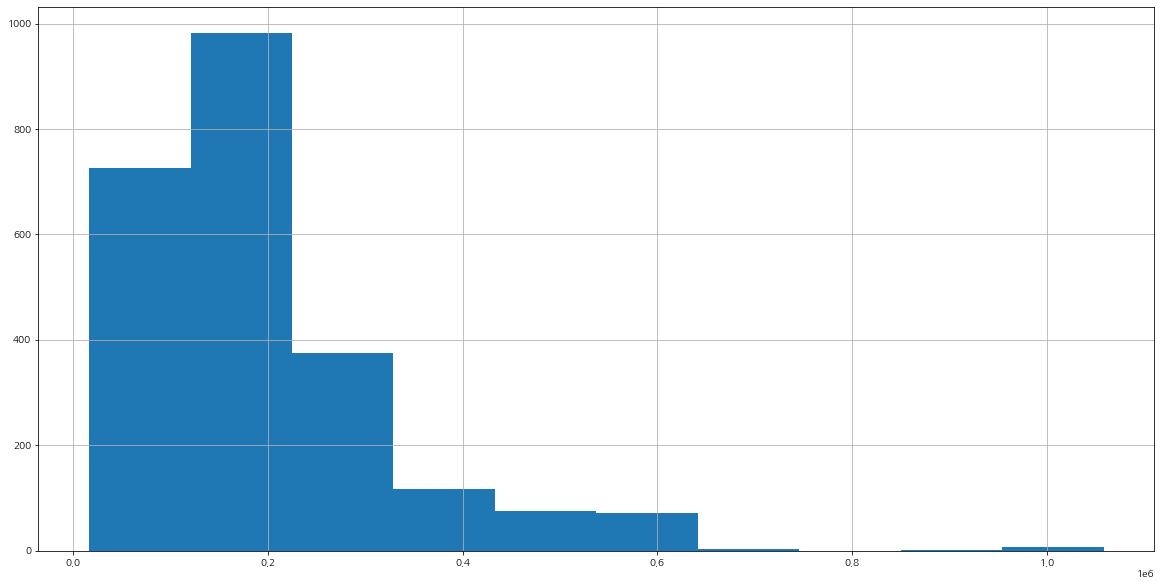

In [114]:
# 임대료
# type: float64

column_check(train_dataset, "임대료", "float64")

도보 10분거리 내 지하철역 수(환승노선 수 반영) 평균: 0.17657789128055454
도보 10분거리 내 지하철역 수(환승노선 수 반영) 표준편차: 0.42740786372992645


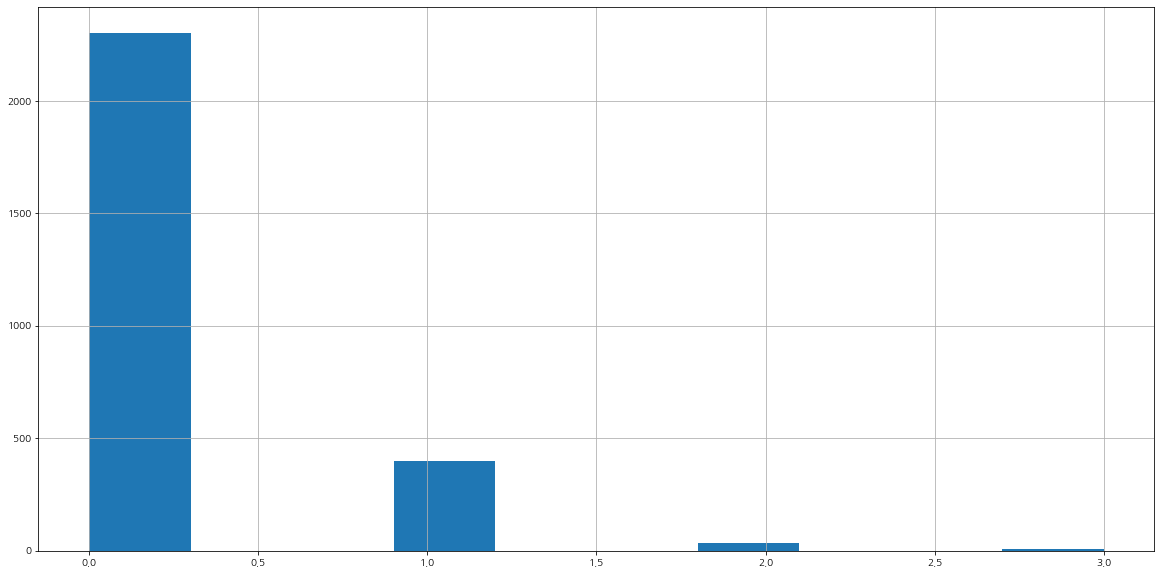

In [115]:
#도보 10분거리 내 지하철역 수(환승노선 수 반영)
# type: float64

column_check(train_dataset, "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "float64")

도보 10분거리 내 버스정류장 수 평균: 3.6957259158751694
도보 10분거리 내 버스정류장 수 표준편차: 2.644665171088132


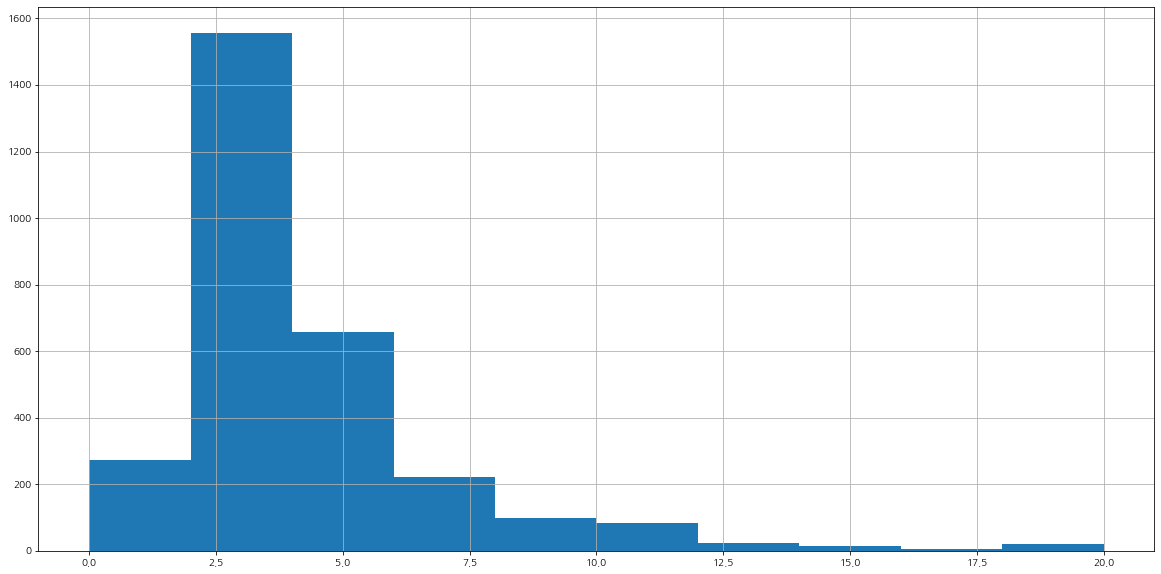

In [116]:
# 도보 10분거리 내 버스정류장 수
# type: float64

column_check(train_dataset, "도보 10분거리 내 버스정류장 수", "float64")

단지내주차면수 평균: 601.6683604336043
단지내주차면수 표준편차: 396.4070719572037


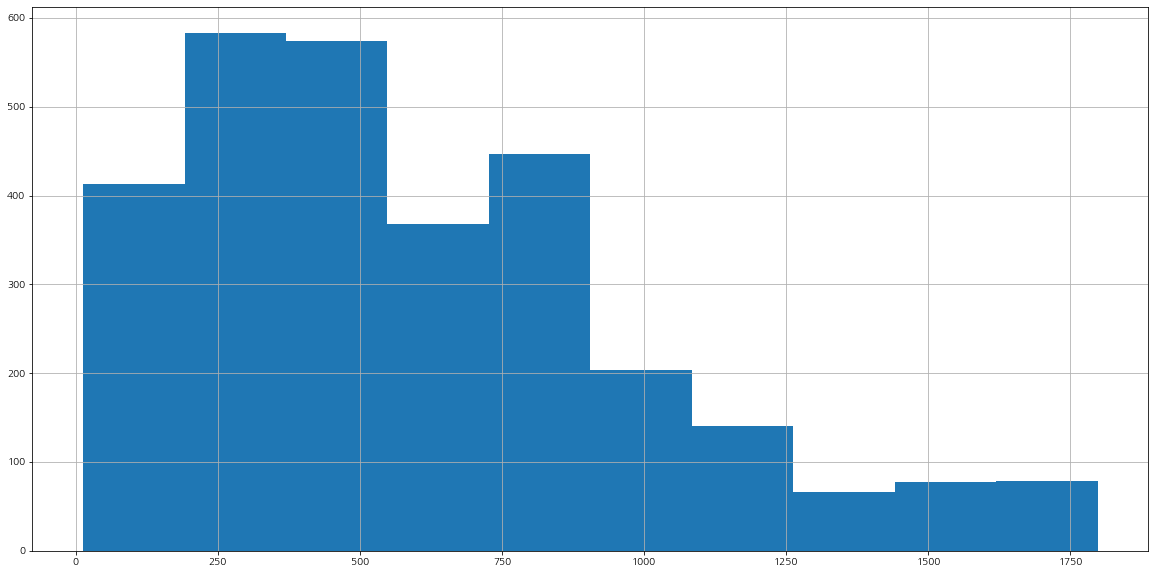

In [117]:
# 단지내주차면수
# type: float64

column_check(train_dataset, "단지내주차면수", "float64")

등록차량수 평균: 559.7682926829268
등록차량수 표준편차: 433.3750266941793


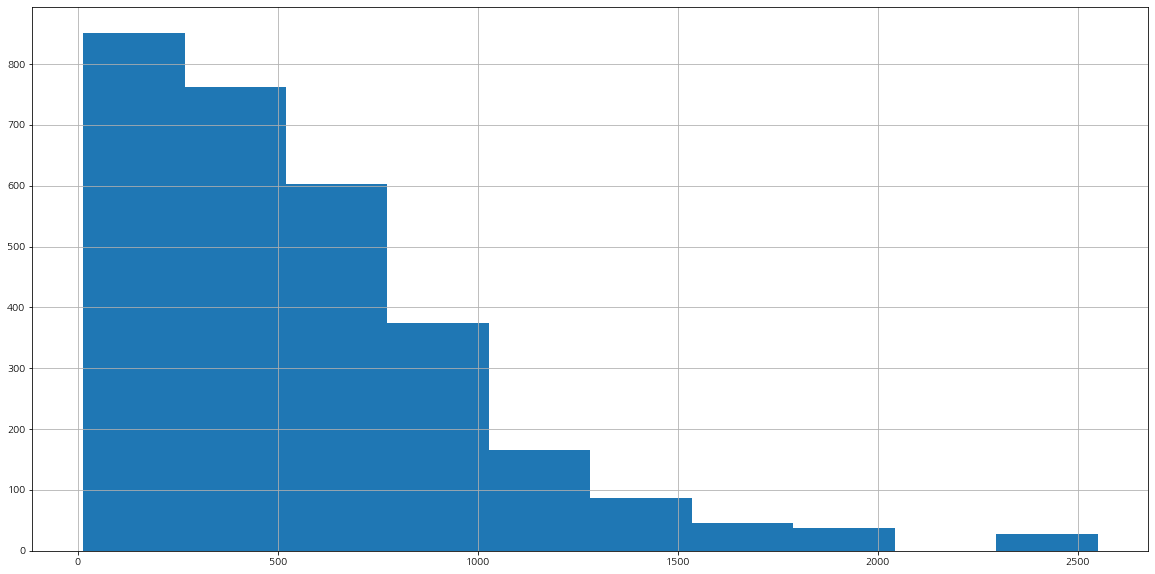

In [118]:
# 등록차량수
# type: float64

column_check(train_dataset, "등록차량수", "float64")

# Target (등록차량수)와의 관계

In [120]:
train_dataset.corr()

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
총세대수,1.000000,0.042271,0.098205,0.068192,0.075493,0.099606,0.213843,-0.001446,0.501488,0.316703
전용면적,0.042271,1.000000,-0.035479,-0.089201,0.490950,0.740591,-0.013111,-0.007866,0.071260,0.115453
전용면적별세대수,0.098205,-0.035479,1.000000,0.166472,-0.099252,-0.057759,-0.056680,0.047112,0.281989,0.247085
공가수,0.068192,-0.089201,0.166472,1.000000,0.030728,-0.194322,-0.093334,0.043285,0.289819,0.118121
임대보증금,0.075493,0.490950,-0.099252,0.030728,1.000000,0.557144,0.027113,0.110757,0.270697,0.311469
임대료,0.099606,0.740591,-0.057759,-0.194322,0.557144,1.000000,0.071571,0.044654,0.279785,0.416536
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.213843,-0.013111,-0.056680,-0.093334,0.027113,0.071571,1.000000,0.098380,-0.055544,-0.108592
도보 10분거리 내 버스정류장 수,-0.001446,-0.007866,0.047112,0.043285,0.110757,0.044654,0.098380,1.000000,0.070696,0.103752
단지내주차면수,0.501488,0.071260,0.281989,0.289819,0.270697,0.279785,-0.055544,0.070696,1.000000,0.859216
등록차량수,0.316703,0.115453,0.247085,0.118121,0.311469,0.416536,-0.108592,0.103752,0.859216,1.000000


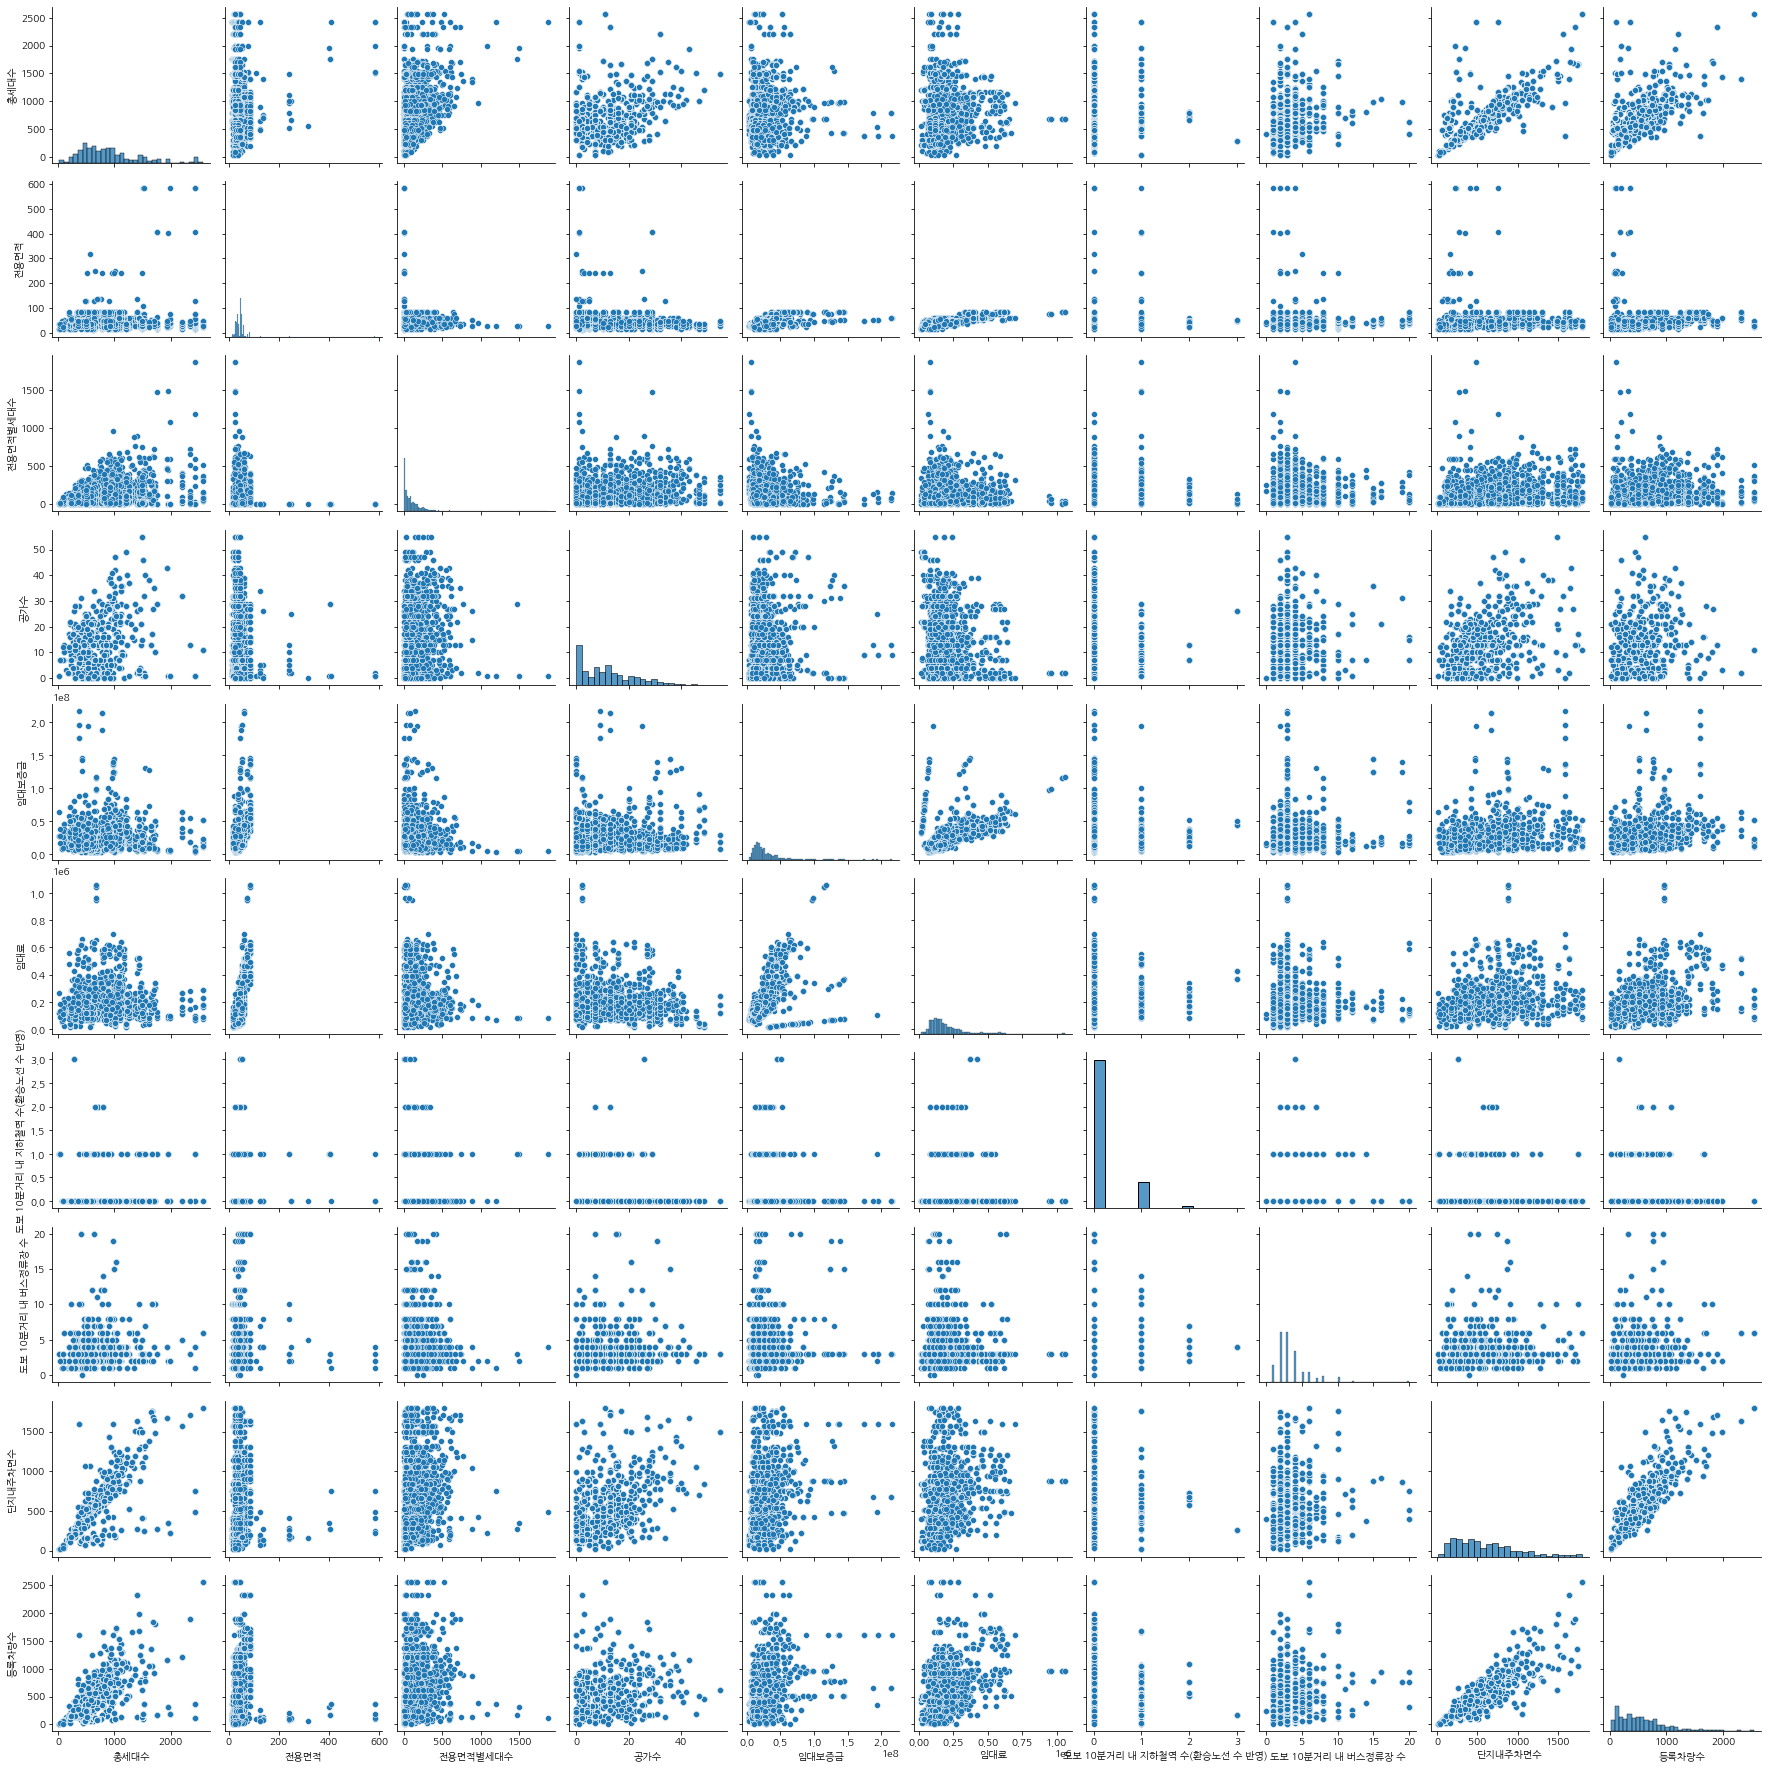

In [139]:
sns.pairplot(train_dataset[num_column])
plt.show()

- 단지내 주차면수 column과 target변수가 가장 높은 상관관계(0.859216)을 가진다.
- 꽤 높은 선형 관계가 있는 것으로 파악된다.
- **단지의 주차면수가 높을 수록 차량 등록이 높아지는 것으로 파악됨.**
- 그 다음으로 임대료(0.416536), 총세대수(0.316703) 순으로 상관관계가 높았음.
- 총 세대수, 단지내주차면수(0.501488)와 임대료와 임대보증금(0.557144)도 어느정도 상관관계가있는 것으로 판단됨.

## Categorical Column

In [185]:
# 단지코드

train_dataset.groupby("단지코드")[num_column].mean()["단지내주차면수"]

단지코드
C1000     438.0
C1004     153.0
C1005     950.0
C1013    1119.0
C1014     823.0
          ...  
C2663     700.0
C2666     837.0
C2670     600.0
C2680     564.0
C2692     409.0
Name: 단지내주차면수, Length: 423, dtype: float64

In [186]:
print(train_dataset.groupby("단지코드")[num_column].std()["단지내주차면수"].sum())
train_dataset.groupby("단지코드")[num_column].std()["단지내주차면수"]

0.0


단지코드
C1000    0.0
C1004    0.0
C1005    0.0
C1013    0.0
C1014    0.0
        ... 
C2663    0.0
C2666    0.0
C2670    0.0
C2680    0.0
C2692    0.0
Name: 단지내주차면수, Length: 423, dtype: float64

In [159]:
# 단지코드

train_dataset.groupby("단지코드")[num_column].mean()["등록차량수"]

단지코드
C1000     481.0
C1004      93.0
C1005     376.0
C1013    1665.0
C1014     708.0
          ...  
C2663     652.0
C2666     701.0
C2670     435.0
C2680     590.0
C2692     437.0
Name: 등록차량수, Length: 423, dtype: float64

In [164]:
print(train_dataset.groupby("단지코드")[num_column].std()["등록차량수"].sum())
train_dataset.groupby("단지코드")[num_column].std()["등록차량수"]

0.0


단지코드
C1000    0.0
C1004    0.0
C1005    0.0
C1013    0.0
C1014    0.0
        ... 
C2663    0.0
C2666    0.0
C2670    0.0
C2680    0.0
C2692    0.0
Name: 등록차량수, Length: 423, dtype: float64

- 단지코드 별로 단지내주차면수,등록차량수가 같은 것으로 보아 등록차량수는 단지내 등록차량임을 알 수 있다. 
- 단지코드 별로 단지내주차면수,등록차량수를 파악.

In [187]:
train_dataset.groupby("단지코드")[["단지내주차면수","등록차량수"]].mean().reset_index(drop=False).corr()

,단지내주차면수,등록차량수
단지내주차면수,1.000000,0.848199
등록차량수,0.848199,1.000000


- unique 단지내 주차면수, 등록차량수
- 여전히 0.848199의 높은 상관관계를 보임.

# 변수별 탐색

## Categorical column

In [147]:
# 단지코드

print(cat_column[0], "unique value 파악")
print(len(train_dataset[cat_column[0]].unique()))
print(train_dataset[cat_column[0]].unique()[:10])

단지코드 unique value 파악
423
['C2483' 'C2515' 'C1407' 'C1945' 'C1470' 'C1898' 'C1244' 'C1171' 'C2073'
 'C2513']


- 423개의 단지코드
- 일종의 unique id이므로 학습에는 큰 영향을 주지 않을 것 같음.
- 위 Target변수와의 관계에서 단지코드 와의 관계 파악 결과, 단지 코드가 같으면 등록차량수는 같은 것으로 파악됨.

In [148]:
# 임대건물구분

print(cat_column[1], "unique value 파악")
print(len(train_dataset[cat_column[1]].unique()))
print(train_dataset[cat_column[1]].unique()[:10])

임대건물구분 unique value 파악
2
['아파트' '상가']


- 임대건물구분은 아파트와 상가 두가지로 구분됨.
- 공급 유형과의 관계 파악이 필요할 듯함.
- one hot encoding 처리.

In [150]:
# 지역 

print(cat_column[2], "unique value 파악")
print(len(train_dataset[cat_column[2]].unique()))
print(train_dataset[cat_column[2]].unique())

지역 unique value 파악
16
['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']


- 지역 이름
- one hot encoding 처리

In [151]:
# 공급유형 

print(cat_column[3], "unique value 파악")
print(len(train_dataset[cat_column[3]].unique()))
print(train_dataset[cat_column[3]].unique())

공급유형 unique value 파악
10
['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']


- 공급 유형별로 10가지의 형태가 존재.
- one hot encoding 처리

In [153]:
# 자격유형  

print(cat_column[4], "unique value 파악")
print(len(train_dataset[cat_column[4]].unique()))
print(train_dataset[cat_column[4]].unique())

자격유형 unique value 파악
15
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O']


- 15가지의 자격 유형으로 나뉨.
- 각 유형별로 의미 파악이 필요해보임.
- one hot encoding 처리.